In [22]:
import numpy as np
from GroupingAlgorithms import *
from functions_VQE_v2 import *
# Importing standard Qiskit libraries
from qiskit import IBMQ
from qiskit.circuit.library import EfficientSU2
from qiskit_nature.transformers import FreezeCoreTransformer
from qiskit_nature.drivers import PyQuanteDriver
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import ParityMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit.opflow import converters
from qiskit.opflow.primitive_ops import Z2Symmetries

In [23]:
IBMQ.load_account()
provider  = IBMQ.get_provider(hub='ibm-q-csic', group='internal', project='iff-csic') 
backend   = provider.get_backend('ibmq_paris')
WC_paris  = get_backend_conectivity(backend)
backend   = providers.aer.AerSimulator(method="statevector") # Backend for simulation
NUM_SHOTS = 2**10  # Number of shots for each circuit

ibmqfactory.load_account:WARNING:2021-05-29 03:32:00,571: Credentials are already in use. The existing account in the session will be replaced.


In [48]:
molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PyQuanteDriver(molecule)
qmolecule = driver.run()
freezeCoreTransfomer = FreezeCoreTransformer(freeze_core=True,remove_orbitals= [3,4])
problem = ElectronicStructureProblem(driver,q_molecule_transformers=[freezeCoreTransfomer])

# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

# Hamiltonian
main_op = second_q_ops[0]

# Setup the mapper and qubit converter
mapper_type = 'ParityMapper'
mapper = ParityMapper()

converter = QubitConverter( mapper=mapper, two_qubit_reduction=True, z2symmetry_reduction=[1,1],) #1] 

# The fermionic operators are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)

num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals

qubit_op = converter.convert(main_op, num_particles=num_particles)

num_qubits = qubit_op.num_qubits
num_qubits = qubit_op.num_qubits
WC=list(range(num_qubits))
WC=list(permutations(list(range(num_qubits)),2))

print( num_qubits )
print( qubit_op )

SummedOp([
  IXZIXY,
  ZXXXXI,
  IXZIYI,
  YIIYYY,
  ZZYXZX,
  XIXYZY,
  YYZYYX,
  XIXXXY,
  YIZYZZ,
  XZZIYZ,
  YZYIZX,
  YYZXIX,
  IIZXIY,
  YIYYYY,
  YYIXXI,
  XXIZZX,
  ZXYXZZ,
  XXYIYY,
  YYYIZX,
  XZZYXI,
  XYIIYY,
  IYIZYI,
  IIXXZZ,
  YYIXZZ,
  ZZYXYI,
  XZIZIZ,
  ZXYYIX,
  IIXIZZ,
  YZZZXY,
  IIXIXY,
  XIYZXI,
  XXYIIX,
  ZXZZZZ,
  XYXIXI,
  XYXYIX,
  IYIXIZ
])


In [59]:
paulis, coeff, label = Label2Chain(qubit_op)
print( 'number of Paulis:', len(coeff) )

Color, Groups_tpb, Measurements_tpb = TPBgrouping(paulis)
print( 'number of TPB groups:', len(Groups_tpb) )
Groups_tpb = [ [ idx2[0] for idx2 in idx1 ] for idx1 in Groups_tpb ]
Measurements_tpb = [ [ [idx[j][0],[j]] for j in range(num_qubits) ] for idx in Measurements_tpb ]

Groups_bell, Measurements_bell = grouping( paulis,[4,3,1,2],WC)
print('number of Bell groups:', len(Groups_bell) )

Groups_bell_paris, Measurements_bell_paris = grouping( paulis,[4,3,1,2],WC_paris)
print('number of Bell groups:', len(Groups_bell_paris) )

number of Paulis: 36
number of TPB groups: 25
number of Bell groups: 22
number of Bell groups: 22


In [7]:
# 0-1-2-3
#   |
#   4

In [8]:
Measurements_bell

[[[4, [2, 3]], [4, [0, 1]]],
 [[1, [2]], [3, [3]], [4, [0, 1]]],
 [[1, [3]], [3, [2]], [4, [0, 1]]],
 [[1, [0]], [3, [1]], [4, [2, 3]]],
 [[1, [1]], [3, [0]], [4, [2, 3]]],
 [[4, [0, 2]], [4, [1, 3]]],
 [[4, [0, 3]], [4, [1, 2]]],
 [[3, [2]], [3, [3]], [3, [1]], [1, [0]]],
 [[3, [2]], [3, [3]], [3, [0]], [1, [1]]],
 [[3, [0]], [3, [1]], [3, [3]], [1, [2]]],
 [[3, [1]], [3, [3]], [1, [0]], [1, [2]]],
 [[3, [0]], [3, [3]], [1, [1]], [1, [2]]],
 [[3, [0]], [3, [1]], [3, [2]], [1, [3]]],
 [[3, [1]], [3, [2]], [1, [0]], [1, [3]]],
 [[3, [0]], [3, [2]], [1, [1]], [1, [3]]]]

In [9]:
Measurements_bell_paris

[[[4, [2, 3]], [4, [0, 1]]],
 [[1, [2]], [3, [3]], [4, [0, 1]]],
 [[1, [3]], [3, [2]], [4, [0, 1]]],
 [[1, [0]], [3, [1]], [4, [2, 3]]],
 [[1, [1]], [3, [0]], [4, [2, 3]]],
 [[1, [2]], [1, [0]], [3, [3]], [3, [1]]],
 [[1, [2]], [1, [1]], [3, [3]], [3, [0]]],
 [[1, [3]], [1, [0]], [3, [2]], [3, [1]]],
 [[1, [3]], [1, [1]], [3, [2]], [3, [0]]]]

In [14]:
entangled_layer = []
for qbs in WC_paris :
    if qbs[0]<qbs[1] and qbs[1]<num_qubits :
        entangled_layer.append(qbs)
entangled_layer

[(0, 1), (1, 2), (2, 3)]

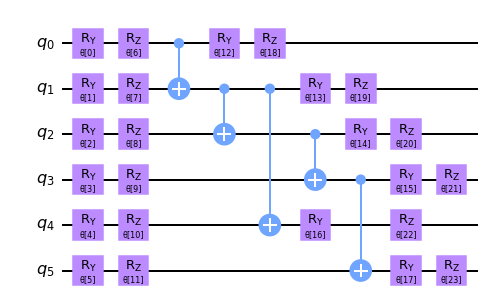

In [60]:
entangled_layer = []
for qbs in WC_paris :
    if qbs[0]<qbs[1] and qbs[1]<num_qubits :
        entangled_layer.append(qbs)

ansatz = EfficientSU2(num_qubits,['ry','rz'], entanglement=entangled_layer, reps=1)
ansatz.draw(output='mpl')

In [11]:
qc = []
n_measure = []
for measure in Measurements_bell :
    qc_temp, n_measure_temp = measure_circuit_factor( measure , num_qubits )
    qc.append( qc_temp )
    n_measure.append( n_measure_temp )

In [61]:
fun1 = lambda params : objective_function(params, coeff, label, Groups_tpb, Measurements_tpb, ansatz, backend, NUM_SHOTS)
fun2 = lambda params : objective_function(params, coeff, label, Groups_bell, Measurements_bell, ansatz, backend, NUM_SHOTS)
fun3 = lambda params : objective_function(params, coeff, label, Groups_bell_paris, Measurements_bell_paris, ansatz, backend, NUM_SHOTS)

In [63]:
num_var = 4*num_qubits
θ = np.random.randn(num_var)

In [21]:
# from scipy.optimize import minimize
# import matplotlib.pyplot as plt
# import numpy as np
# from functions_VQE import objective_function, from_string_to_numbers
# from qiskit import *
# from GroupingAlgorithms import grouping
# from itertools import permutations
# from qiskit.circuit.library import EfficientSU2
# from qiskit.aqua.operators.legacy import WeightedPauliOperator
# from qiskit.quantum_info import Pauli
# from qiskit.aqua.algorithms import NumPyEigensolver, VQE
# from qiskit.aqua.components.optimizers import COBYLA


# def get_var_form(params, qr, cr):
#     """
#     Generate the variational circuit using a efficientSU2 circuit, with linear entanglements between qubits (the cnot
#     gates are only applied to neighbours qubits). Each repetition of the circuit is formed by a R_y and R_z to all the
#     qubits, and then the cnot gates.

#     Parameters
#     ----------
#     param (numpy.array): Array with the values of the angles of each one qubit rotation gate
#     reps (Optional, int): Number of repetitions for the variational circuit

#     Return
#     ------
#     (qiskit.circuit) of N qubits and N classical registers, with the variational form
#     """
#     qc = QuantumCircuit(*qr,
#                         *cr)  # Create a quantum circuit with classical registers, so later we can concatenate circuits

#     # Create variational circuit (without classical register), and substitute the parameters of each gate
#     qc_temp = EfficientSU2(num_qubits, entanglement='full', reps=n_rep).bind_parameters(params)

#     return qc.compose(qc_temp)  # Add a  classical register to the circuit


# def create_pauli_qiskit(weights, labels):
#     """
#     Transform a Pauli Weight in form of dictionary into a qiskit operator. To preforms this transformation we construct
#     a list, in which each elements is another list of the form [weight, Pauli].

#     Parameters
#     ----------
#     pauli (dic{'str': complex}): Each keys is a string representing the Pauli chains, e.g., 'IXXZ', and the values are
#                                given by the weight of each Pauli string.

#     Returns
#     -------
#     (WeightedPauliOperator) qiskit operator

#     """
#     temp = []  # List in which save the weights and the Pauli strings
#     for label, weight in zip(labels, weights):  # Iterate over all the Pauli strings
#         temp.append([weight, Pauli(label)])
#     return WeightedPauliOperator(temp)  # Transform the list into a qiskit operator


# initial_state = np.array([0, -1j * np.sqrt(5) / 2, -1 / 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
# initial_state = initial_state / np.linalg.norm(initial_state)

# backend = Aer.get_backend("qasm_simulator")  # Backend for simulation
# NUM_SHOTS = 100000  # Number of shots for each circuit
# classical_optimizer = 'COBYLA'
# basis = [4, 6, 7, 8, 9, 5, 3, 2, 1]

# num_qubits = 2
# n_rep = 4
# num_vars = num_qubits * 2 * (
#         n_rep + 1)  # Number of parameters of the variational circuit, one parameters for each R_z and R_y
# WC = list(permutations(list(range(num_qubits)), 2))

# # lower and upper bound for variables
# bounds = [[-2 * np.pi, 2 * np.pi]] * num_vars  # From 0 to 2 pi ??

# # construct the bounds in the form of constraints
# cons = []
# for factor in range(len(bounds)):
#     lower, upper = bounds[factor]
#     l = {'type': 'ineq',
#          'fun': lambda x, lb=lower, i=factor: x[i] - lb}
#     u = {'type': 'ineq',
#          'fun': lambda x, ub=upper, i=factor: ub - x[i]}
#     cons.append(l)
#     cons.append(u)

# Pauli_weights = [1, 5, -1]
# Pauli_labels = ['XX', 'YY', 'XZ']

# pauli_qiskit = create_pauli_qiskit(Pauli_weights, Pauli_labels)
# exact_result = NumPyEigensolver(pauli_qiskit).run()
# exact_energy = np.real(exact_result.eigenvalues)[0]
# print('The exact energy is {:.3f}'.format(exact_energy))

# PS = from_string_to_numbers(Pauli_labels)
# Groups, Measurements = grouping(PS, basis, WC)

# # optimizer = COBYLA(maxiter=1000, disp=True)
# # vqe = VQE(pauli_qiskit, EfficientSU2(num_qubits, entanglement='full', reps=n_rep), optimizer)
# # results = vqe.run(backend)
# # vqe_result = np.real(results['eigenvalue'])
# # print(vqe_result)

# initial_params = np.random.rand(num_vars)  # Initialize the parameters for the variational circuit with random values
# result = minimize(objective_function, initial_params,
#                   args=(Pauli_weights, Pauli_labels, Groups, Measurements, get_var_form, backend, NUM_SHOTS),
#                   options={'maxiter': 1000, 'disp': True}, constraints=cons, method=classical_optimizer)
